In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import pandas as pd
import scipy.sparse as sp
from sklearn.metrics import explained_variance_score

from sklearn.decomposition import non_negative_factorization as SKNMF

import time, random, gc
from termcolor import cprint
from threadpoolctl import threadpool_limits
import os

import muon as mu 
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import scanpy as sc
import anndata as ad
from pathlib import Path


/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cnmf

In [3]:
cnmf_obj = cnmf.cNMF(output_dir="/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/cNMF_100_07102024", name="consensus_NMF")

In [31]:
hundred = cnmf_obj.combine_nmf(100)

Combining factorizations for k=100.


In [34]:
def program_corr(matrix1,matrix2):
    
    if matrix2.shape != matrix2.shape:
        print("dim is different")
        return 
    
    num_columns = matrix1.shape[0]
    column_correlations = []
    
    for i in range(num_columns):
        for j in range(num_columns):
            
            # Calculate the correlation coefficient between the i-th row of matrix1 and j-th row of matrix2
            correlation = np.corrcoef(matrix1.iloc[i,:], matrix2.iloc[j,:])[0, 1]
            column_correlations.append(correlation)
            
    df = pd.DataFrame(np.array(column_correlations).reshape(num_columns, num_columns), 
                     columns = matrix2.index,
                     index = matrix1.index)

    return df


def program_euclidean(matrix1, matrix2):
    
    if matrix1.shape != matrix2.shape:
        print("dim is different")
        return 
    
    num_rows = matrix1.shape[0]
    euclidean_distances = []
    
    for i in range(num_rows):
        for j in range(num_rows):
            
            # Calculate the Euclidean distance between the i-th row of matrix1 and j-th row of matrix2
            distance = np.sqrt(np.sum((matrix1.iloc[i,:] - matrix2.iloc[j,:])**2))
            euclidean_distances.append(distance)
            
    df = pd.DataFrame(np.array(euclidean_distances).reshape(num_rows, num_rows), 
                     columns=matrix2.index,
                     index=matrix1.index)

    return df

In [ ]:
cor = program_corr(hundred,hundred)

In [35]:
distance = program_euclidean(hundred,hundred)

In [83]:
# For graphing clustermap given corr matrix
def graph_cluster(matrix, method = 'single', save = False, save_folder_name = None , save_file_name = None ):
 
    # label color for each run 
    #palette = sns.color_palette("tab10", n_colors=matrix.columns.nunique())
    #lut = dict(zip(matrix.columns.unique(), palette))
    #row_colors = matrix.columns.map(lut)
    
    sns.set_theme(style="white")               # optional aesthetics
    g = sns.clustermap(
            matrix,
            cmap="vlag",                       # diverging palette centred at 0
            #linewidths=.5,                     # grid lines
            center=0,                          # keep 0 in the middle of the colour range
            metric="euclidean",                # distance metric for clustering
            method= method,                    # linkage method
            figsize=(10, 10),                  # size in inches
            #row_colors=row_colors,            # color axis 
            #col_colors = row_colors,          # color axis 
            row_cluster=True,
            col_cluster=True
    )

    # drop names, too many names now
    # Remove axis labels and tick labels
    #g.ax_heatmap.set_xlabel('')
    #g.ax_heatmap.set_ylabel('')
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.set_yticklabels([])

    g.fig.suptitle(save_file_name)


    # Remove dendrograms
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)

    # Remove tick marks/lines
    g.ax_heatmap.tick_params(left=False, right= False, bottom=False)

    plt.show()

    if save:
        g.savefig(f"{save_folder_name}/{save_file_name}.png")
    
    return g
    

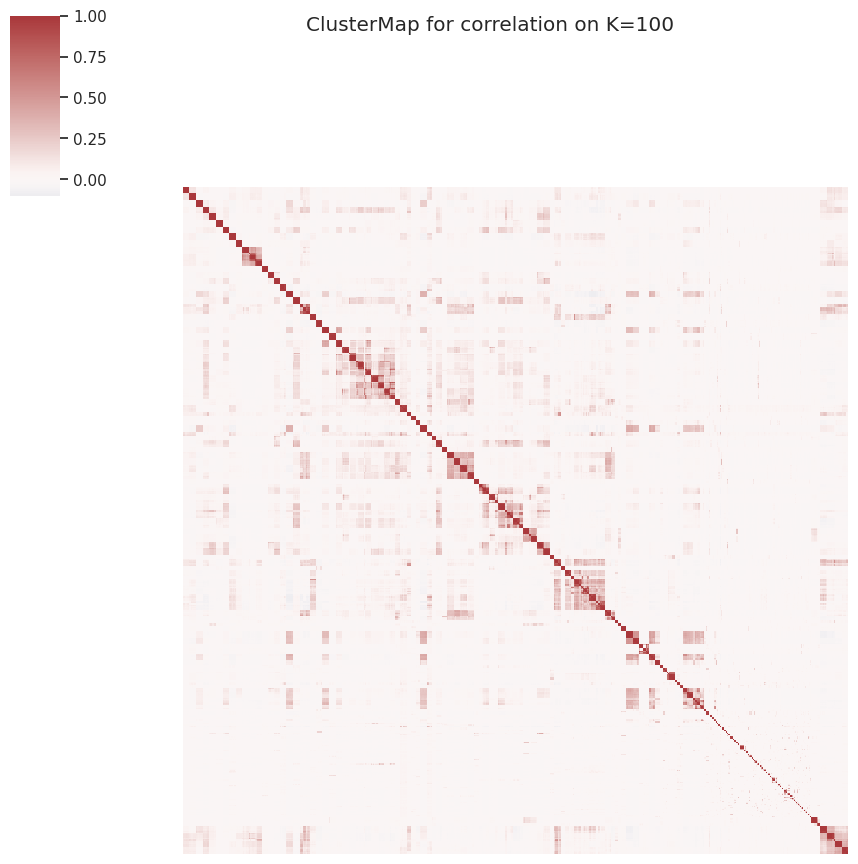

In [84]:
graph_cluster(cor, save_file_name="ClusterMap for correlation on K=100")

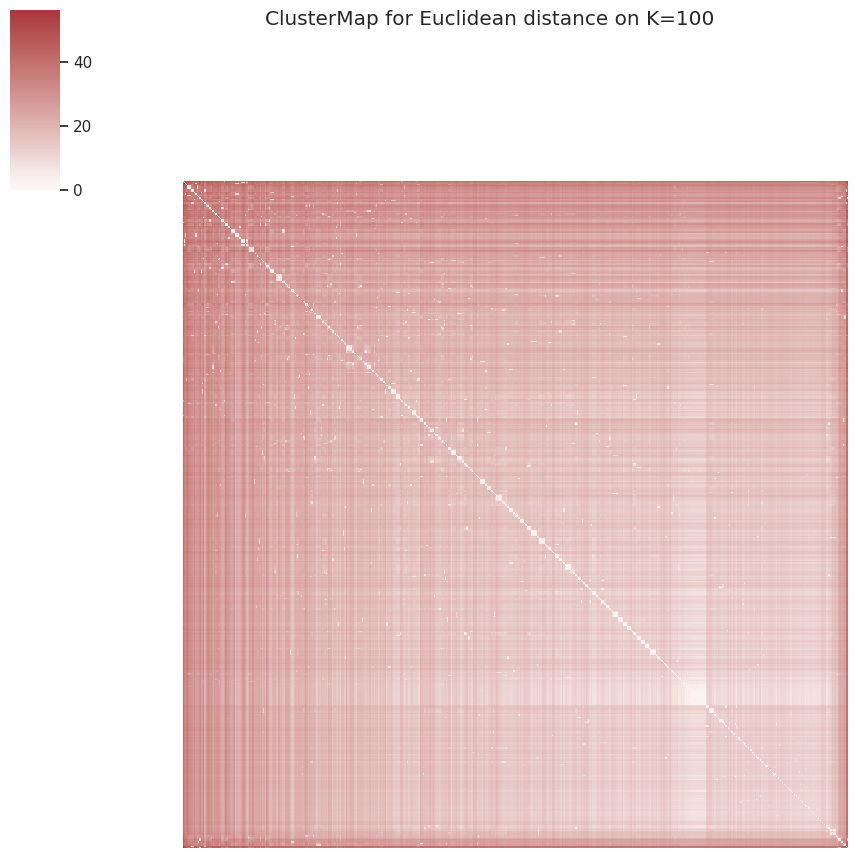

In [85]:
graph_cluster(distance, save_file_name="ClusterMap for Euclidean distance on K=100")

In [76]:
# generate matrix with each entry overlap/300 
def top_genes_overlap(matrix1, matrix2, gene_num = 300):
    
    # check dim 
    if matrix1.shape != matrix2.shape:
        print("Different dim")
        return 
    
    # find out top x genes in each k
    top_genes_1 = matrix1.apply(lambda row: row.nlargest(gene_num).index.tolist(), axis=1)
    top_genes_2 = matrix2.apply(lambda row: row.nlargest(gene_num).index.tolist(), axis=1)

    
    n_k = (top_genes_1.shape[0])
    overlap = np.zeros((n_k, n_k), dtype=float)
    gene_shared_list = pd.Series(dtype=object)

    # generate overlap matrix 
    for i in range(n_k):
        for j in range(n_k):
            s = len(set(top_genes_1.iloc[i]) & set(top_genes_2.iloc[j]))/gene_num

            # compose a shared gene matrix
            #gene_shared = list(set(top_genes_1.iloc[i]) & set(top_genes_2.iloc[j]))
            #name = f"{top_genes_1.index[i]} VS {top_genes_2.index[j]}"
            #gene_shared_list.at[name] = gene_shared 
            
            overlap[i, j] = s

    
    overlap_df = pd.DataFrame(overlap,
                              index=matrix1.index,
                              columns=matrix2.index)
    
    return overlap_df#, top_genes_1, top_genes_2, gene_shared_list

# graph heatmap
def graph_heatmap(g, r, c, folder_name, file_name, num_gene = 300, sorted = False):

    mat = g.data2d.to_numpy() * num_gene

    assert mat.shape[0] % r == 0 and mat.shape[1] % c == 0, \
           "Rows/cols must divide evenly by block size."

    n_row_blocks = mat.shape[0] // r
    n_col_blocks = mat.shape[1] // c

    blocks = (mat.reshape(n_row_blocks, r, n_col_blocks, c)
            .swapaxes(1, 2)              
            .reshape(-1, r, c))

    block_means = (blocks.mean(axis=(1, 2))).astype(int)
    plt.figure(figsize=(12, 8))
    sns.heatmap(block_means.reshape(10,10),annot=True, cmap='inferno_r',fmt='d')        
    plt.title("Heatmap for matching programs " + file_name)

    g.savefig(f"{folder_name}/{file_name}.png")
 
    plt.show()

    # Sorted heatmap
    if sorted: 
        matrix = block_means.reshape(10,10).tolist()

        for i in range(len(matrix)):
            max_index = matrix[i].index(max(matrix[i]))
            # Swap max element with the diagonal element
            matrix[i][i], matrix[i][max_index] = matrix[i][max_index], matrix[i][i]

        plt.figure(figsize=(12, 8))
        sns.heatmap(np.array(matrix).reshape(r,c),annot=True, cmap='inferno_r',fmt='d')        
        plt.title("Sorted Heatmap for matching programs " + file_name)

        g.savefig(f"{folder_name}/{file_name}_sorted.png")
 
        plt.show()


In [78]:
overlap_df = top_genes_overlap(hundred,hundred)

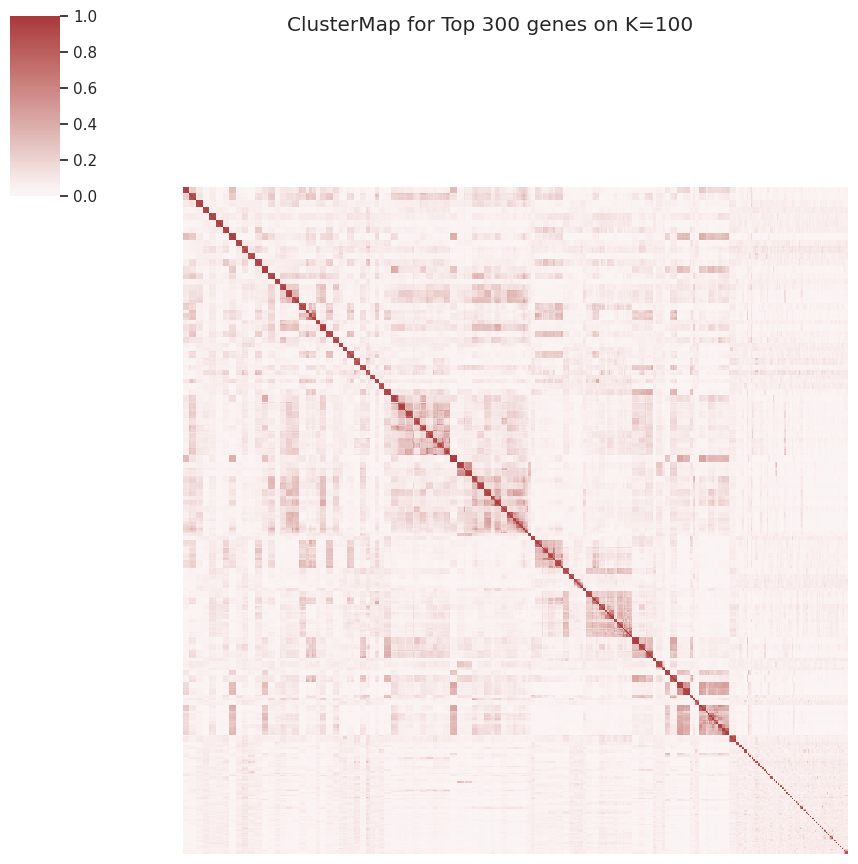

In [86]:

graph_cluster(overlap_df, save_file_name="ClusterMap for Top 300 genes on K=100")